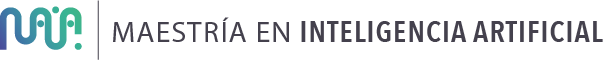

#### **IA Biomédica:** Laboratorio PharmaNet: Funciones Avanzadas


> ##### Descubrimiento de Farmacos


> **Instructores**

*  Julio Castellanos


## 📝 Laboratorio: Uso Avanzado para el Descubrimiento de Fármacos

En este laboratorio profundizaremos en la interpretación de los resultados de inferencia y modificaremos el modelo original para entrenarlo con nuestros propios targets.

Al final de esta sesión, se espera haber logrado lo siguiente:

- Entrenar un modelo exclusivamente con datos de targets seleccionados (i.e: proteínas como Thymidine Kinase (KITH) y Fatty Acid-Binding Protein (FABP4)).
- Hacer plots de la la función de perdida y NAP
- Realizar el preprocesamiento de los resultados de inferencia para mejorar su interpretación.
- Validar los datos en UniProt y hacer interpretación estructural con AlphaFold y Boltz-1 en Fastfold.


### Referencias:

- PharmaNet: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0241728
- KITH: https://www.uniprot.org/uniprotkb/P04183/entry#sequences
- FABP4: https://www.uniprot.org/uniprotkb/P04183/entry#sequences
- Alphafold: https://www.nature.com/articles/s41586-024-07487-w
- Boltz-1: https://www.biorxiv.org/content/10.1101/2024.11.19.624167v1
- Fastfold: https://www.fastfold.ai

### Modelo

<p align="center"><img src="Overview.png" /></p>


### Top Targets 

<p align="center"><img src="data/lab/top_targets.png" /></p>






## 1. Imports

In [1]:
# ## 1. Importaciones Principales

from __future__ import division, print_function

import copy
import os
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from tqdm import tqdm

# Modulos propios (asegúrate de tener estas rutas en tu proyecto)
from data.data_loader import SMILESDataset
from utils.metrics import pltauc, norm_ap_optimized
from models.Model import Model


print("PyTorch Version: ", torch.__version__)

/Users/juliocesar/miniforge3/envs/PharmaNet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version:  1.9.0.post2


## 2. Configuración de Parámetros y Semilla

En esta sección, definimos los parámetros necesarios para la ejecución:
- GPU o CPU
- Fijación de semilla aleatoria para reproducibilidad

In [2]:
# 2. Configuración de Parámetros y Semilla

seed = 6766

torch.manual_seed(seed)
np.random.seed(seed)

# Configurar GPU (si está disponible)
ngpu = 1
os.environ['CUDA_VISIBLE_DEVICES'] = '{}'.format(ngpu)
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

if device == 'cuda':
    torch.cuda.manual_seed(seed)

print("Dispositivo seleccionado:", device)

Dispositivo seleccionado: cpu


## 3. Lectura de Datos

Tomamos los datos y filtramos las filas para mantener solo los registros con Target “kith” o “fabp4”, convierte esos valores a etiquetas numéricas (1 para “kith” y 0 para “fabp4”), ordena los datos por la etiqueta y finalmente guarda los resultados filtrados y ordenados en archivos CSV separados para entrenamiento y prueba.


In [3]:
# 3. Lectura de Datos
train_path = "data/datasets/DUDE/"
A = pd.read_csv(train_path + 'Smiles_1.csv')
B = pd.read_csv(train_path + 'Smiles_2.csv')
C = pd.read_csv(train_path + 'Smiles_3.csv')
D = pd.read_csv(train_path + 'Smiles_4.csv')

data_train = pd.concat([A, B, C], ignore_index=True)
data_test = D

# Filtrado de los datos para conservar solo las filas con Targets deseados
targets_to_keep = ['kith', 'fabp4', 'cxcr4', 'comt', 'hmdh', 'akt1', 'ada17']
label_mapping = {'fabp4': 0, 'kith': 1, 'cxcr4': 2, 'comt': 3, 'hmdh': 4, 'akt1': 5, 'ada17': 6}

# Para data_train: filtrar, seleccionar las columnas deseadas, actualizar la columna Label y ordenar
filtered_train = data_train[data_train['Target'].isin(targets_to_keep)][['Smiles', 'Target', 'Label']].copy()
filtered_train['Label'] = filtered_train['Target'].map(label_mapping)
filtered_train = filtered_train.sort_values(by='Label')
filtered_train.to_csv(train_path + "LAB_TRAIN/train_data.csv", index=False)

# Para data_test: filtrar, seleccionar las columnas deseadas, actualizar la columna Label y ordenar
filtered_test = data_test[data_test['Target'].isin(targets_to_keep)][['Smiles', 'Target', 'Label']].copy()
filtered_test['Label'] = filtered_test['Target'].map(label_mapping)
filtered_test = filtered_test.sort_values(by='Label')
filtered_test.to_csv(train_path + "LAB_TRAIN/test_data.csv", index=False)


# Filtrar y guardar datos para entrenamiento
filtered_train = data_train[data_train['Target'].isin(targets_to_keep)][['Smiles', 'Target', 'Label']].copy()
filtered_train['Label'] = filtered_train['Target'].map(label_mapping)
filtered_train = filtered_train.sort_values(by='Label')
filtered_train = filtered_train.reset_index(drop=True)  # Reset index
filtered_train.to_csv(os.path.join(train_path, "LAB_TRAIN/train_data.csv"), index=False)

# Filtrar y guardar datos para test
filtered_test = data_test[data_test['Target'].isin(targets_to_keep)][['Smiles', 'Target', 'Label']].copy()
filtered_test['Label'] = filtered_test['Target'].map(label_mapping)
filtered_test = filtered_test.sort_values(by='Label')
filtered_test = filtered_test.reset_index(drop=True)  # Reset index
filtered_test.to_csv(os.path.join(train_path, "LAB_TRAIN/test_data.csv"), index=False)

# Luego, al asignar los datos para el dataset:
data_train = filtered_train
data_test = filtered_test

print('Data for train:', len(data_train['Smiles']))
print('Data for test :', len(data_test['Smiles']))


Data for train: 792
Data for test : 274


## 4. Preparación del Vocabulario (charset) y Definición de Longitud Máxima
Extraemos un conjunto de caracteres únicos usados en los SMILES y calculamos la longitud máxima de la secuencia.

In [4]:
# 4. Vocabulario y Embedding
charset = set("".join(list(data_train.Smiles)) + "".join(list(data_test.Smiles)))
vocab_size = len(charset)
char_to_int = dict((c, i) for i, c in enumerate(charset))

embed_tr = max([len(smile) for smile in data_train.Smiles])
embed_te = max([len(smile) for smile in data_test.Smiles])
embed = max(embed_tr, embed_te)

print('Caracteres únicos:', str(charset))
print('Total de caracteres:', vocab_size)
print('Max. longitud de SMILE:', embed)

Caracteres únicos: {'B', '=', '7', '8', '1', '@', 'S', 'O', 'o', '-', '4', 'I', '(', 'l', 'P', '/', 'r', '\\', 's', '2', 'N', '[', 'C', '6', ')', '5', 'n', 'c', 'H', ']', 'F', '#', '3'}
Total de caracteres: 33
Max. longitud de SMILE: 112


## 5. Construcción del Modelo (PharmaNet)

Se instancia la clase `Model(...)` que define la arquitectura Conv + RNN.  
Luego se imprime el modelo para revisar su estructura.

In [5]:

# 5. Construcción del Modelo
num_classes = max(data_train.Label) + 1
print(num_classes)
hidden_size = 256
kernel_size = 5

bidireccional = True
num_layers = 10

net = Model(vocab_size,
            num_classes,
            hidden_size,
            bidireccional,
            num_layers,
            kernel_size
            ).to(device)

print(net)

7
Model(
  (module_mol): ModuleList(
    (0): Conv2d(33, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(3, 2))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GRU(128, 256, num_layers=10, batch_first=True, bidirectional=True)
    (5): Upsample(size=64, mode=nearest)
  )
  (fc1): Linear(in_features=512, out_features=7, bias=True)
)


## 6. Definición del Optimizador y la Función de Pérdida

Usamos Adam como optimizador y BCELoss (aplicando `sigmoid` en cada clase).  
El scheduler reduce el learning rate si no hay mejoras.

In [6]:
# 6. Optimizador y Pérdida
optimizer = optim.Adam(net.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=7)
criterion = nn.BCELoss()

## 7. Creación de los DataLoaders (Train/Test)

Se definen:
- El dataset con la clase `SMILESDataset`.
- DataLoader con sampler balanceado o shuffle, según los argumentos.

In [7]:
# 7. DataLoaders

neighbours = 0
padding = False

batch_size = 128
workers = 5

train_datasets = SMILESDataset(data_train, vocab_size, char_to_int, embed, neighbours, padding)
test_datasets  = SMILESDataset(data_test, vocab_size, char_to_int, embed, neighbours, padding)


train_loader = DataLoader(train_datasets, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=workers)
test_loader  = DataLoader(test_datasets,  batch_size=batch_size, drop_last=True, shuffle=True, num_workers=workers)

print("Train loader y test loader creados.")

Train loader y test loader creados.


## 8. Funciones de Entrenamiento y Evaluación

- **train(epoch)**: Modo `train()`, calcula pérdida y backprop.
- **evaluate(epoch)**: Modo `eval()`, sin backprop, y se calculan métricas finales (NAP, AUC, etc.).

In [8]:
def train(epoch):
    # Coloca el modelo en modo entrenamiento (permite dropout, actualiza gradientes)
    net.train()

    running_loss = 0.0
    running_corrects = 0
    lab = np.array([])                       # Para almacenar etiquetas reales
    maps = np.empty((0, num_classes))        # Para almacenar predicciones (probabilidades)

    # Iteramos sobre cada batch (inputs, _, labels) proveniente de train_loader
    for inputs, _, labels in tqdm(train_loader):
        # Convertimos a tensores en float32 y los movemos al dispositivo (CPU/GPU)
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        labels = labels.to(device)

        # Reiniciamos gradientes antes de cada batch
        optimizer.zero_grad()

        # Activamos el cálculo de gradientes
        with torch.set_grad_enabled(True):
            # Forward pass: obtenemos outputs de la red
            outputs = net(inputs)
            loss = 0

            # Para cada clase, calculamos el aporte a la pérdida usando BCELoss
            for i in range(num_classes):
                labe = labels.clone()
                labe[labels == i] = 1
                labe[labels != i] = 0
                loss += criterion(F.sigmoid(outputs[:, i].float()), labe.float().to(device))

            # Convertimos outputs a numpy para calcular métricas (softmax de outputs)
            outputs_array = F.softmax(outputs.clone().detach().cpu(), dim=1).numpy()
            maps = np.append(maps, outputs_array, axis=0)

            # Guardamos las etiquetas en un array para métricas
            labels_array = labels.clone().cpu().detach().numpy()
            lab = np.append(lab, labels_array)

            # Obtenemos la predicción (clase con mayor probabilidad)
            _, preds = torch.max(outputs, 1)

            # Backprop: calculamos gradientes y actualizamos pesos
            loss.backward()
            optimizer.step()

        # Acumulamos pérdida total del batch
        running_loss += loss.item() * inputs.size(0)

        # Calculamos aciertos para accuracy
        running_corrects += torch.sum(preds == labels.data)

    # Pérdida media en la época
    epoch_loss = running_loss / len(train_loader.dataset)
    # Precisión en la época
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    # Cálculo de métricas: NAP y AUC (incluye macro y micro)
    epoch_nap, epoch_f = norm_ap_optimized(maps, lab, num_classes)
    epoch_auc = pltauc(maps, lab, num_classes)

    # Imprimimos métricas clave
    print('Phase Train, Loss: {:.4f} Acc: {:.4f} NAP: {:.4f} F-measure: {:.4f} AUC: {:.4f}'.format(
        epoch_loss, epoch_acc, epoch_nap[-1], epoch_f[-1], epoch_auc["micro"]))

    # Retornamos valores relevantes para graficar o almacenar
    return epoch_loss, epoch_acc, epoch_nap[-1], epoch_f[-1], epoch_auc["micro"]


def evaluate(epoch):
    net.eval()

    running_loss = 0.0
    running_corrects = torch.tensor(0.0, device=device)  # Changed initialization

    lab = np.array([])
    maps = np.empty((0, num_classes))

    # Iterate over validation data
    for inputs, _, labels in test_loader:
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            outputs = net(inputs)
            loss = 0
            for i in range(num_classes):
                labe = labels.clone()
                labe[labels == i] = 1
                labe[labels != i] = 0
                loss += criterion(F.sigmoid(outputs[:, i].float()), labe.float().to(device))

            outputs_array = F.softmax(outputs.clone().detach().cpu(), dim=1).numpy()
            maps = np.append(maps, outputs_array, axis=0)
            labels_array = labels.clone().cpu().detach().numpy()
            lab = np.append(lab, labels_array)
            _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(test_loader.dataset)
    
    # Update scheduler using the aggregated loss
    scheduler.step(epoch_loss)
    for param_group in optimizer.param_groups:
        print(param_group['lr'])
        
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
    epoch_nap, epoch_f = norm_ap_optimized(maps, lab, num_classes)                
    epoch_auc = pltauc(maps, lab, num_classes)
    
    predictions = [maps, lab]
    
    print('Phase Validation, Loss: {:.4f} Acc: {:.4f} NAP: {:.4f} F-measure: {:.4f} auc:  {:.4f}'.format(
        epoch_loss, epoch_acc, epoch_nap[-1], epoch_f[-1], epoch_auc["micro"]))
    
    return epoch_loss, epoch_acc, epoch_nap[-1], epoch_f[-1], epoch_auc["micro"], predictions

## 9. Plots de Metricas 

Graficamos la metricas para hacer seguimiento al progreso en tiempo de ejecucion del entrenamiento

In [9]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(d_losses, g_losses, save_dir, num_epoch, save=True, show=False):
    fig, ax = plt.subplots()
    ax.set_xlim(0,num_epoch)
    ax.set_ylim(0, max(np.max(g_losses), np.max(d_losses))*1.1)
    plt.xlabel('Epoch {0}'.format(num_epoch))
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Train')
    plt.plot(g_losses, label='Test')
    plt.legend()
    
    # Save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'losses_{:d}'.format(num_epoch) + '.png'
        plt.savefig(save_fn)
    if show:
        plt.show()
    else:
        plt.close()

def plot_nap(d_losses, g_losses, f_losses, td_losses, tg_losses, tf_losses, save_dir, num_epoch, save=True, show=False):
    fig, ax = plt.subplots()
    ax.set_xlim(0,num_epoch)
    ax.set_ylim(0, max(np.max(g_losses), np.max(d_losses), np.max(f_losses))*1.1)
    plt.xlabel('Epoch {0}'.format(num_epoch))
    plt.ylabel('metric values')
    plt.plot(d_losses, label='Test nap')
    plt.plot(g_losses, label='Test AUC')
    plt.plot(f_losses, label='Test accuracy')
    plt.plot(td_losses, label='Train nap')
    plt.plot(tg_losses, label='Train AUC')
    plt.plot(tf_losses, label='Train accuracy')
    plt.legend()
    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'nap{:d}'.format(num_epoch) + '.png'
        plt.savefig(save_fn)
    if show:
        plt.show()
    else:
        plt.close()

## 10. Bucle Principal de Entrenamiento

Controla el número de épocas, guarda el mejor modelo según la métrica (NAP, por ejemplo) y produce gráficas de evolución.

In [10]:
initial_epoch = 0
num_epochs = 2

results_dir = './PharmaNet'
results_path = 'Lab_Advanced'

# Historial para gráficas
train_losses_history, val_losses_history = [], []
train_acc_history, val_acc_history = [], []
train_nap_history, val_nap_history = [], []
train_f_history, val_f_history = [], []
train_auc_history, val_auc_history = [], []

best_model_wts = copy.deepcopy(net.state_dict())
saving_path_models = os.path.join(results_dir, results_path, 'model_1'+'/')
if not os.path.exists(saving_path_models):
    os.makedirs(saving_path_models, 0o777)

def main():
    since = time.time()
    best_NAP = 0
    best_prediction = None

    for epoch in range(initial_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Entrenar
        train_loss, train_acc, train_nap, train_f, train_auc = train(epoch)
        train_losses_history.append(train_loss)
        train_acc_history.append(train_acc)
        train_auc_history.append(train_auc)
        train_nap_history.append(train_nap)
        train_f_history.append(train_f)

        # Validar
        val_loss, val_acc, val_nap, val_f, val_auc, prediction_nap = evaluate(epoch)
        val_losses_history.append(val_loss)
        val_acc_history.append(val_acc)
        val_auc_history.append(val_auc)
        val_nap_history.append(val_nap)
        val_f_history.append(val_f)

        # Guardar el mejor modelo si la métrica (NAP) mejora
        if val_nap > best_NAP:
            best_NAP = val_nap
            best_prediction = prediction_nap
            best_model_wts = copy.deepcopy(net.state_dict())
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_losses_history
            }, os.path.join(saving_path_models, 'Checkpoint.pth'))
            
        # Graficar loss y nap
        
        plot_loss(train_losses_history,
                val_losses_history, 
                saving_path_models,
                num_epochs,
                show=True)
        plot_nap(val_nap_history, val_auc_history, 
                torch.tensor(val_acc_history).cpu().tolist(),
                train_nap_history, train_auc_history, 
                torch.tensor(train_acc_history).cpu().tolist(),
                saving_path_models,
                num_epochs,
                show=True)   
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val NAP: {:4f}'.format(best_NAP))
    print('Best val ACC: {:4f}'.format(max(val_acc_history)))
    print('Best val AUC: {:4f}'.format(max(val_auc_history)))
    print('Best val Fscore: {:4f}'.format(max(val_f_history)))

    net.load_state_dict(best_model_wts)
    torch.save({
        'model': net.state_dict(),
        'optimize': optimizer.state_dict(),
        'prediction': best_prediction,
        'charset': char_to_int,
        'embed': embed
    }, os.path.join(saving_path_models, 'model.pth'))

## 11. Ejecucion de Entrenamiento


In [17]:

run_train = True

if run_train:
    main()

Epoch 0/1
----------


100%|██████████| 6/6 [03:02<00:00, 30.41s/it]

Phase Train, Loss: 2.9944 Acc: 0.3333 NAP: 0.2771 F-measure: 0.2747 AUC: 0.4942


0.0005
Phase Validation, Loss: 2.2323 Acc: 0.4161 NAP: 0.3827 F-measure: 0.4133 auc:  0.5358
Epoch 1/1
----------


100%|██████████| 6/6 [03:15<00:00, 32.59s/it]

Phase Train, Loss: 2.2716 Acc: 0.4381 NAP: 0.3012 F-measure: 0.2979 AUC: 0.5140


0.0005
Phase Validation, Loss: 2.2336 Acc: 0.4161 NAP: 0.2783 F-measure: 0.3258 auc:  0.5025
Training complete in 7m 18s
Best val NAP: 0.382696
Best val ACC: 0.416058
Best val AUC: 0.535819
Best val Fscore: 0.413256


## 10. Inferencia usando Torch Save

**Preparación de predicciones**
Tras la inferencia, se acumulan las salidas softmax (all_outputs), las etiquetas reales (all_labels) y se calculan las predicciones con np.argmax para determinar la etiqueta con mayor probabilidad.

**Guardado con torch.save**
Se crea un diccionario llamado predictions que contiene las salidas, las etiquetas reales y las etiquetas predichas. Luego, este diccionario se guarda en un archivo llamado test_predictions.pth en la ruta saving_path_models.

In [12]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

from data.data_loader import SMILESDataset
from utils.metrics import pltmap, pltauc, norm_ap
from models.Model import Model

def inference_example(
    data_test,           # DataFrame con SMILES y etiquetas
    saving_path_models,  # Ruta donde está el modelo entrenado (model.pth)
    device,              # "cuda" o "cpu"
    num_classes,         # Cantidad de clases/targets esperadas en el modelo
    hidden_size,         # Tamaño hidden para la red
    bidireccional,       # Boolean, si la RNN es bidireccional
    num_layers,          # Número de capas en la RNN
    kernel_size,         # Tamaño kernel para convolución
    neighbours,          # Parámetro extra para SMILESDataset
    padding,             # Padding usado en SMILESDataset
    batch_size,          # Tamaño de batch para DataLoader
    workers              # Num. de workers para DataLoader
):
    """
    Ejemplo simplificado de inferencia con PharmaNet.
    - data_test: DataFrame con columnas ['Smiles','Label']
    - Se asume que 'model.pth' contiene ['model','charset','embed'].
    """
    print("Cargando modelo desde:", saving_path_models)
    model_path = os.path.join(saving_path_models, 'model.pth')
    trained_model = torch.load(model_path, map_location=device)

    # Reconstruir diccionario de caracteres y embed
    char_to_int_inf = trained_model['charset']
    embed_inf       = trained_model['embed']
    vocab_size_inf  = len(char_to_int_inf)

    # Reconstruir el modelo con los mismos hiperparámetros
    model_infer = Model(
        vocab_size_inf,
        num_classes,
        hidden_size,
        bidireccional,
        num_layers,
        kernel_size
    ).to(device)

    model_infer.load_state_dict(trained_model['model'])
    model_infer.eval()

    # Crear dataset de prueba
    test_dataset_inf = SMILESDataset(
        data_test,
        vocab_size_inf,
        char_to_int_inf,
        embed_inf,
        neighbours,
        padding
    )

    test_loader_inf = DataLoader(
        test_dataset_inf,
        batch_size=batch_size,
        drop_last=False,
        shuffle=False,
        num_workers=workers
    )

    all_outputs = np.empty((0, num_classes))
    all_labels  = np.array([])

    # Bucle de inferencia
    for inputs, _, labels in tqdm(test_loader_inf, desc="Inferencia"):
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model_infer(inputs)    # (batch_size, num_classes)
            out_soft = F.softmax(outputs, dim=1).cpu().numpy()
            all_outputs = np.append(all_outputs, out_soft, axis=0)

            # Guardamos las etiquetas reales para métricas
            labels_np = labels.cpu().numpy()
            all_labels = np.append(all_labels, labels_np)

    # ===================
    # Cálculo de métricas
    # ===================
    unique_classes = np.unique(all_labels)
    if len(unique_classes) < num_classes:
        print(f"Warning: Se esperaban {num_classes} clases, pero solo se encontraron {len(unique_classes)} en el test.")
    
    # Intentamos calcular cada métrica y, si falla, asignamos un valor por defecto.
    try:
        epoch_nap, epoch_f = norm_ap(all_outputs, all_labels, num_classes=num_classes)
    except Exception as e:
        print("Error al calcular NAP:", e)
        epoch_nap, epoch_f = [0.0], [0.0]
    
    try:
        epoch_ap, _ = pltmap(all_outputs, all_labels, num_classes=num_classes)
    except Exception as e:
        print("Error al calcular MAP:", e)
        epoch_ap = {"micro": 0.0}
    
    try:
        # Si hay menos de dos clases presentes, evitamos el cálculo de AUC
        if len(unique_classes) < 2:
            print("Solo hay una clase en los datos. No se puede calcular AUC.")
            epoch_auc = {"micro": 0.0, "macro": 0.0}
        else:
            epoch_auc = pltauc(all_outputs, all_labels, num_classes=num_classes)
    except Exception as e:
        print("Error al calcular AUC:", e)
        epoch_auc = {"micro": 0.0, "macro": 0.0}

    # Accuracy
    preds = np.argmax(all_outputs, axis=1)
    running_corrects = np.sum(preds == all_labels)
    epoch_acc = running_corrects / len(all_labels) if len(all_labels) > 0 else 0.0

    print(f"\n[RESULTADOS DE INFERENCIA]")
    print(f"  NAP: {epoch_nap[-1]:.4f}")
    print(f"  AP (micro): {epoch_ap['micro']:.4f}")
    print(f"  AUC (micro): {epoch_auc['micro']:.4f}")
    print(f"  Accuracy: {epoch_acc:.4f}\n")

    # Preparar un diccionario con las predicciones finales
    predictions = {
        'outputs': all_outputs,           # Salidas softmax para cada muestra
        'labels': all_labels,             # Etiquetas reales
        'predicted_labels': preds         # Etiquetas predichas (argmax)
    }

    # Guardar las predicciones finales usando torch.save
    save_path = os.path.join(saving_path_models, 'test_predictions.pth')
    torch.save({
        'prediction': predictions
    }, save_path)
    print("Final predictions saved to:", save_path)

    return {
        "NAP": epoch_nap[-1],
        "AP_micro": epoch_ap["micro"],
        "AUC_micro": epoch_auc["micro"],
        "Accuracy": epoch_acc
    }

# Ejemplo de uso:
# Se asume que ya tienes definidos data_test, saving_path_models, device, num_classes,
# hidden_size, bidireccional, num_layers, kernel_size, neighbours, padding, batch_size y workers.
resultados = inference_example(
     data_test=data_test,
     saving_path_models=saving_path_models,
     device="cpu",
     num_classes=num_classes,
     hidden_size=hidden_size,
     bidireccional=bidireccional,
     num_layers=num_layers,
     kernel_size=kernel_size,
     neighbours=neighbours,
     padding=padding,
     batch_size=batch_size,
     workers=workers
)
print(resultados)

Cargando modelo desde: ./PharmaNet/Lab_Advanced/model_1/


Inferencia: 100%|██████████| 3/3 [00:35<00:00, 11.74s/it]



[RESULTADOS DE INFERENCIA]
  NAP: 0.2722
  AP (micro): 0.1582
  AUC (micro): 0.5937
  Accuracy: 0.4453

Final predictions saved to: ./PharmaNet/Lab_Advanced/model_1/test_predictions.pth
{'NAP': 0.2721622513264338, 'AP_micro': 0.15823164987230323, 'AUC_micro': 0.5937184595146274, 'Accuracy': 0.44525547445255476}


### Inferencia a targets especificos

In [18]:
data_validation = pd.read_csv('data/datasets/DUDE/LAB_TRAIN/inference_validation.csv')
data_validation

,Smiles,Target,Label
0,Nc1ncnc2n(cnc12)[C@@H]1O[C@H](COP([O-])(=O)OP(...,kith,1
1,[H][C@]12CC[C@]3(C)[C@@H](O)CC[C@@]3([H])[C@]1...,comt,3



**Proteina 1**
Target: Thymidine Kinase (KITH)

<p align="center"><img style="width: 350px" src="https://raw.githubusercontent.com/juliocesar-io/PharmaNet/refs/heads/main/data/lab/KITH.png" /></p>


Fuente: Resultado prediccion en https://cloud.fastfold.ai con Boltz-1

Sequencia: 

```
MSCINLPTVLPGSPSKTRGQIQVILGPMFSGKSTELMRRVRRFQIAQYKCLVIKYAKDTRYSSSFCTHDRNTMEALPACLLRDVAQEALGVAVIGIDEGQFFPDIVEFCEAMANAGKTVIVAALDGTFQRKPFGAILNLVPLAESVVKLTAVCMECFREAAYTKRLGTEKEVEVIGGADKYHSVCRLCYFKKASGQPAGPDNKENCPVPGKPGEAVAARKLFAPQQILQCSPAN
```


**Molecula (SMILES) 1**

ATP

<p align="center"><img style="width: 150px" src="https://raw.githubusercontent.com/juliocesar-io/PharmaNet/refs/heads/main/data/lab/atp.png" /></p>

Secuencia:
```
Nc1ncnc2n(cnc12)[C@@H]1O[C@H](COP([O-])(=O)OP([O-])(=O)OP([O-])([O-])=O)[C@@H](O)[C@H]1O
```

Ref: https://www.uniprot.org/uniprotkb/P04183/entry#sequences


**Proteina 2**
Target: Catechol O-methyltransferase (COMT)

<p align="center"><img style="width: 350px" src="https://raw.githubusercontent.com/juliocesar-io/PharmaNet/refs/heads/main/data/lab/COMT.png" /></p>


Fuente: Resultado prediccion en https://cloud.fastfold.ai con Boltz-1

Sequencia: 

```
MGDTKEQRILNHVLQHAEPGNAQSVLEAIDTYCEQKEWAMNVGDKKGKIVGAVIQEHQPFVLLELGAYCGYSAVRMARLLSPGARLITIEINPDCAAITQRMVDFAGVKDKVTLVVGASQDIIPQLKKKYDVDTLDMVFLDHWKDRYLPDTLLLEECGLLRRGTVLLADNVICPGAPDFLAHVRGSSCFECTHYQSFLEYREVVDGLEKAIYKGPGSEAGP
```

**Molecula (SMILES) 2**

S-adenosyl-L-methionine zwitterion

<p align="center"><img style="width: 150px" src="https://raw.githubusercontent.com/juliocesar-io/PharmaNet/refs/heads/main/data/lab/S-adenosyl-L-methionine.png" /></p>

Secuencia:
```
C[S+](CC[C@H]([NH3+])C([O-])=O)C[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cnc2c(N)ncnc12
```

Ref: https://www.uniprot.org/uniprotkb/P04183/entry#sequences

In [61]:

data_validation = pd.read_csv('data/datasets/DUDE/LAB_TRAIN/inference_validation.csv')

resultados = inference_example(
     data_test=data_validation,
     saving_path_models=saving_path_models,
     device="cpu",
     num_classes=num_classes,
     hidden_size=hidden_size,
     bidireccional=bidireccional,
     num_layers=num_layers,
     kernel_size=kernel_size,
     neighbours=neighbours,
     padding=padding,
     batch_size=batch_size,
     workers=workers
)
print(resultados)

Cargando modelo desde: ./PharmaNet/Lab_Advanced/model_1/


Inferencia: 100%|██████████| 1/1 [00:06<00:00,  6.76s/it]


Error al calcular AUC: Only one class present in y_true. ROC AUC score is not defined in that case.

[RESULTADOS DE INFERENCIA]
  NAP: nan
  AP (micro): 0.2143
  AUC (micro): 0.0000
  Accuracy: 0.0000

Final predictions saved to: ./PharmaNet/Lab_Advanced/model_1/test_predictions.pth
{'NAP': nan, 'AP_micro': 0.21428571428571427, 'AUC_micro': 0.0, 'Accuracy': 0.0}


### 11. Interpretacion Inferencia

In [92]:
# TIP: You can inspect a pth file with https://netron.app/ online.


def plot_predictions(maps, label_mapping, smiles=None, lab=None, path=None):
    """
    Plot the probability distribution for each sample.
    The highest probability is highlighted with a dotted outline and a horizontal dotted line.
    
    Parameters:
      maps: np.array of model probabilities (N x num_classes)
      label_mapping: dict mapping labels to indices
      smiles (optional): np.array of SMILES strings for each sample
      lab (optional): np.array of ground-truth labels for each sample
    """
    num_samples = len(maps)
    # Create a list of label names in the format "label(index)"
    labels = [f"{label}({idx})" for label, idx in label_mapping.items()]
    x = np.arange(len(labels))
    
    for i in range(num_samples):
        probs = maps[i]
        plt.figure(figsize=(8, 4))
        
        # Plot the bars (convert probabilities to percentage)
        bars = plt.bar(x, probs * 100, align='center', alpha=0.7)
        
        # Determine the maximum probability index and value
        max_index = probs.argmax()
        max_prob_percent = probs[max_index] * 100
        
        # Highlight the highest probability bar:
        # - Set a red dotted outline on the highest bar
        bars[max_index].set_edgecolor('red')
        bars[max_index].set_linewidth(2)
        bars[max_index].set_linestyle('--')
        
        # Draw a horizontal dotted line at the highest probability level
        plt.axhline(y=max_prob_percent, color='red', linestyle='--', linewidth=1)
        
        # Annotate the highest probability value above the corresponding bar
        plt.text(x[max_index], max_prob_percent + 1, f"{max_prob_percent:.1f}%", 
                 ha='center', color='red', fontweight='bold')
        
        # Set the x-axis tick labels
        plt.xticks(x, labels, rotation=45)
        plt.xlabel('Labels')
        plt.ylabel('Probability (%)')
        
        # Use SMILES as title if provided; otherwise, just sample number
        title_str = f"Sample #{i}"
        if smiles is not None:
            title_str += f": {smiles[i]}"
        plt.title(title_str)
        
        plt.tight_layout()
        plt.show()
        plt.savefig(f"{path}/prediction_{i}.png")

def display_predictions(maps, label_mapping, smiles=None, lab=None):
    """
    Display the probability distribution for each sample.
    
    Parameters:
      maps: np.array of model probabilities (N x num_classes)
      label_mapping: dict mapping labels to indices
      smiles (optional): np.array of SMILES strings for each sample
      lab (optional): np.array of ground-truth labels for each sample
    """
    for i in range(len(maps)):
        print("Sample #", i)
        if smiles is not None:
            print("  SMILES:   ", smiles[i])
            
        # Convert each probability to a percentage string with 5 decimal places
        percentage_probs = [f"{p * 100:.5f}%" for p in maps[i]]
        
        # Create a dictionary mapping each label (with index) to its corresponding probability percentage
        labeled_percentage_probs = {
            f"{label}({idx})": percentage_probs[idx] 
            for label, idx in label_mapping.items()
        }
        
        # Identify the index of the highest probability for this sample
        max_index = maps[i].argmax()
        highest_prob = maps[i][max_index]
        
        # Get the corresponding label for the highest probability, with a default if not found
        highest_label = next((label for label, idx in label_mapping.items() if idx == max_index), f"Index {max_index}")
        
        # Create a dictionary for the highest probability using the "label(index)" format
        labeled_percentage_highest_probs = {
            f"{highest_label}({max_index})": f"{highest_prob * 100:.1f}%"
        }
        
        print("  Labeled ProbDist %:", labeled_percentage_probs)
        print("  Highest Probability:", labeled_percentage_highest_probs)
        print()  # Empty line for readability

# --- Example usage with the fully trained model branch ---
use_fully_trained_model = False

if use_fully_trained_model:
    checkpoint = torch.load(os.path.join("PharmaNet/Best_Config/model1", 'test_predictions.pth'))
    
    
    # here we get the original label mapping
    df = pd.read_csv('data/datasets/DUDE/Smiles_1.csv')
    unique_targets = df.drop_duplicates(subset='Target')
    label_mapping = dict(zip(unique_targets['Target'], unique_targets['Label']))
    
    # Extract the 'prediction' entry which contains [smiles, maps, lab]
    predictions_map = checkpoint['prediction']
    smiles = predictions_map[0]  # np.array of SMILES strings
    maps   = predictions_map[1]  # np.array of model probabilities (N x num_classes)
    lab    = predictions_map[2]  # np.array of ground-truth class labels

    print("SMILES array shape:", smiles.shape)
    print("Probability array shape:", maps.shape)
    print("Labels array shape:", lab.shape)
    
    # Use the reusable function to display predictions for each sample
    display_predictions(maps, label_mapping, smiles=smiles, lab=lab)
    # plot_predictions(maps, label_mapping, path="PharmaNet/Best_Config/model1")
    
else:
    # Use an alternative checkpoint path
    label_mapping = {'fabp4': 0, 'kith': 1, 'cxcr4': 2, 'comt': 3, 'hmdh': 4, 'akt1': 5, 'ada17': 6}
    checkpoint = torch.load(os.path.join(saving_path_models, 'test_predictions.pth'))
    
    # Extract the 'prediction' entry (here, we assume it returns a dict with key 'outputs')
    predictions_map = checkpoint['prediction']
    maps = predictions_map['outputs']  # np.array of model probabilities (N x num_classes)
    
    print("Probability array shape:", maps.shape)
    
    # Use the reusable function without SMILES and ground-truth labels
    display_predictions(maps, label_mapping)
    plot_predictions(maps, label_mapping, path=saving_path_models)

Probability array shape: (2, 7)
Sample # 0
  Labeled ProbDist %: {'fabp4(0)': '4.23546%', 'kith(1)': '4.77052%', 'cxcr4(2)': '3.73392%', 'comt(3)': '3.05080%', 'hmdh(4)': '6.04587%', 'akt1(5)': '20.28843%', 'ada17(6)': '57.87501%'}
  Highest Probability: {'ada17(6)': '57.9%'}

Sample # 1
  Labeled ProbDist %: {'fabp4(0)': '19.31451%', 'kith(1)': '17.74733%', 'cxcr4(2)': '17.84510%', 'comt(3)': '22.97921%', 'hmdh(4)': '12.81689%', 'akt1(5)': '5.96058%', 'ada17(6)': '3.33638%'}
  Highest Probability: {'comt(3)': '23.0%'}

